In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks

In [2]:
using Plots

In [3]:
using DifferentialEquations

In [4]:
n_x = 101
n_y = 101
n_vsa = 1

1

In [5]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [6]:
phases = collect([[x, y] for x in range(-1.0, 1.0, n_x), y in range(-1.0, 1.0, n_y)]) |> stack
phases = reshape(phases, (1,2,:));

In [7]:
b = v_bind(phases, dims=2);

In [8]:
ub = v_unbind(phases[1:1,1:1,:], phases[1:1,2:2,:]);

In [10]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [13]:
spk_args.solver_args

Dict{Symbol, Any} with 4 entries:
  :adaptive   => false
  :sensealg   => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(Zygote…
  :dt         => 0.01
  :save_start => true

In [14]:
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [16]:
st_x = phase_to_train(phases[1:1,1:1,:], spk_args = spk_args, repeats = repeats)
st_y = phase_to_train(phases[1:1,2:2,:], spk_args = spk_args, repeats = repeats)

Spike Train: (1, 1, 10201) with 61206 spikes.

In [17]:
st_xg = SpikeTrainGPU(st_x)
st_yg = SpikeTrainGPU(st_y)

SpikeTrainGPU(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(1, 1, 2), CartesianIndex(1, 1, 3), CartesianIndex(1, 1, 4), CartesianIndex(1, 1, 5), CartesianIndex(1, 1, 6), CartesianIndex(1, 1, 7), CartesianIndex(1, 1, 8), CartesianIndex(1, 1, 9), CartesianIndex(1, 1, 10)  …  CartesianIndex(1, 1, 10192), CartesianIndex(1, 1, 10193), CartesianIndex(1, 1, 10194), CartesianIndex(1, 1, 10195), CartesianIndex(1, 1, 10196), CartesianIndex(1, 1, 10197), CartesianIndex(1, 1, 10198), CartesianIndex(1, 1, 10199), CartesianIndex(1, 1, 10200), CartesianIndex(1, 1, 10201)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], (1, 1, 10201), 10201, 0.0f0)

In [18]:
@time sol_out = v_bind(st_x, st_y, tspan=tspan, spk_args=spk_args, return_solution=true)

  8.289281 seconds (9.88 M allocations: 2.403 GiB, 39.05% gc time, 57.04% compilation time: 2% of which was recompilation)


#143 (generic function with 1 method)

In [19]:
@time spk_out = v_bind(st_x, st_y, tspan=tspan, spk_args=spk_args, return_solution=false)

  5.348183 seconds (6.61 M allocations: 2.270 GiB, 33.91% gc time, 50.88% compilation time)


Spike Train: (1, 1, 10201) with 57035 spikes.

In [20]:
typeof(sol_out) <: Function

true

In [21]:
tbase = 0.0:0.01:6.0 |> collect

601-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 5.89
 5.9
 5.91
 5.92
 5.93
 5.94
 5.95
 5.96
 5.97
 5.98
 5.99
 6.0

In [22]:
uv = sol_out.(tbase)

601-element Vector{Array{ComplexF64, 3}}:
 [0.0 + 0.0im;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; 0.0 + 0.0im]
 [-7.902187706630356e-5 - 6.21388817852067e-7im;;; -7.902455650929743e-5 - 3.3299344823971115e-9im;;; -5.094375673602054e-5 + 3.727253606501278e-7im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; -7.902187706630356e-5 - 6.21388817852067e-7im]
 [-0.00021300009240446394 - 5.7964986556568836e-6im;;; -0.0002591438476072863 - 3.5291322501118487e-6im;;; -0.00021317231814145868 - 6.492375221526896e-9im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; -0.00021300009240446394 - 5.7964986556568836e-6im]
 [-0.00028586219274756575 - 1.857197986496759e-5im;;; -0.0003962669046669101 - 1.7300838842356295e-5im;;; -0.00039676943559395494 - 8.427342771046443e-6im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; -0.00028586219274756575 - 1.857197986496759e-5im]
 [-0.00030426403820649553 - 3.6136422837377506e-5im;;; -0.00044867869136485175 - 4.085502384688303e-5im;;; -0.0005086139920820604 - 3.008

In [23]:
stack(uv, dims=ndims(uv[1])+1)

1×1×10201×601 Array{ComplexF64, 4}:
[:, :, 1, 1] =
 0.0 + 0.0im

[:, :, 2, 1] =
 0.0 + 0.0im

[:, :, 3, 1] =
 0.0 + 0.0im

;;; … 

[:, :, 10199, 1] =
 0.0 + 0.0im

[:, :, 10200, 1] =
 0.0 + 0.0im

[:, :, 10201, 1] =
 0.0 + 0.0im

[:, :, 1, 2] =
 -7.902187706630356e-5 - 6.21388817852067e-7im

[:, :, 2, 2] =
 -7.902455650929743e-5 - 3.3299344823971115e-9im

[:, :, 3, 2] =
 -5.094375673602054e-5 + 3.727253606501278e-7im

;;; … 

[:, :, 10199, 2] =
 0.0 + 0.0im

[:, :, 10200, 2] =
 0.0 + 0.0im

[:, :, 10201, 2] =
 -7.902187706630356e-5 - 6.21388817852067e-7im

[:, :, 1, 3] =
 -0.00021300009240446394 - 5.7964986556568836e-6im

[:, :, 2, 3] =
 -0.0002591438476072863 - 3.5291322501118487e-6im

[:, :, 3, 3] =
 -0.00021317231814145868 - 6.492375221526896e-9im

;;; … 

[:, :, 10199, 3] =
 0.0 + 0.0im

[:, :, 10200, 3] =
 0.0 + 0.0im

[:, :, 10201, 3] =
 -0.00021300009240446394 - 5.7964986556568836e-6im

;;;; … 

[:, :, 1, 599] =
 -0.011298229601557241 + 0.0012494386542753946im

[:, :, 2, 599] =


In [24]:
@time sol_out.(tbase)

  1.404032 seconds (87.16 k allocations: 3.064 GiB, 17.28% gc time)


601-element Vector{Array{ComplexF64, 3}}:
 [0.0 + 0.0im;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; 0.0 + 0.0im]
 [-7.902187706630356e-5 - 6.21388817852067e-7im;;; -7.902455650929743e-5 - 3.3299344823971115e-9im;;; -5.094375673602054e-5 + 3.727253606501278e-7im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; -7.902187706630356e-5 - 6.21388817852067e-7im]
 [-0.00021300009240446394 - 5.7964986556568836e-6im;;; -0.0002591438476072863 - 3.5291322501118487e-6im;;; -0.00021317231814145868 - 6.492375221526896e-9im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; -0.00021300009240446394 - 5.7964986556568836e-6im]
 [-0.00028586219274756575 - 1.857197986496759e-5im;;; -0.0003962669046669101 - 1.7300838842356295e-5im;;; -0.00039676943559395494 - 8.427342771046443e-6im;;; … ;;; 0.0 + 0.0im;;; 0.0 + 0.0im;;; -0.00028586219274756575 - 1.857197986496759e-5im]
 [-0.00030426403820649553 - 3.6136422837377506e-5im;;; -0.00044867869136485175 - 4.085502384688303e-5im;;; -0.0005086139920820604 - 3.008

In [25]:
@time u = stack(sol_out.(tbase));

  2.238503 seconds (92.61 k allocations: 3.155 GiB, 41.09% gc time, 0.38% compilation time)


In [26]:
u |> size

(1, 1, 10201, 601)

In [27]:
using .PhasorNetworks: find_spikes_rf, normalize_potential, spiking_offset

In [28]:
u2 = normalize_potential.(u);

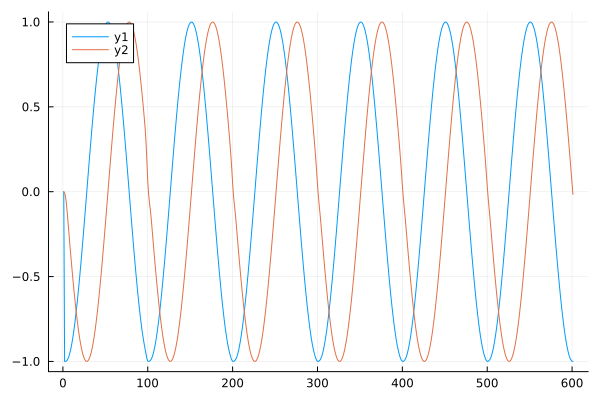

In [29]:
plot(real.(u2[1,1,1,:]))
plot!(imag.(u2[1,1,1,:]))

In [30]:
size(u2)

(1, 1, 10201, 601)

In [33]:
rec_phases = potential_to_phase(u2, tbase, spk_args=spk_args);

In [34]:
rec_phases |> size

(1, 1, 10201, 601)

In [38]:
fp2 = rec_phases[:,:,:,450];

In [39]:
err_2 = vec(b) .- vec(fp2);

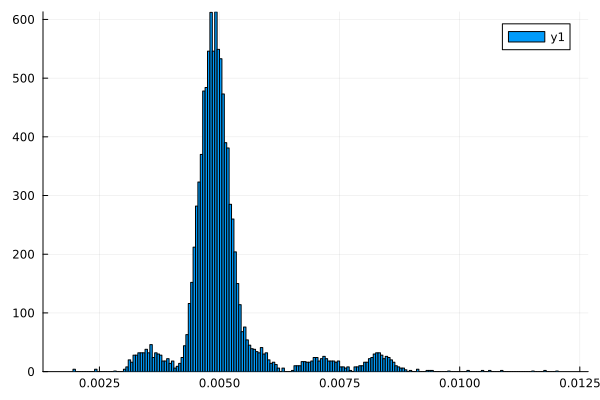

In [40]:
histogram(filter(x -> abs(x) < 0.25, err_2))

In [41]:
spk = find_spikes_rf(u2, tbase, spk_args, dim=-1)

(CartesianIndex{3}[CartesianIndex(1, 1, 910), CartesianIndex(1, 1, 911), CartesianIndex(1, 1, 912), CartesianIndex(1, 1, 913), CartesianIndex(1, 1, 914), CartesianIndex(1, 1, 915), CartesianIndex(1, 1, 916), CartesianIndex(1, 1, 917), CartesianIndex(1, 1, 918), CartesianIndex(1, 1, 919)  …  CartesianIndex(1, 1, 9226), CartesianIndex(1, 1, 9326), CartesianIndex(1, 1, 9426), CartesianIndex(1, 1, 9526), CartesianIndex(1, 1, 9626), CartesianIndex(1, 1, 9726), CartesianIndex(1, 1, 9826), CartesianIndex(1, 1, 9926), CartesianIndex(1, 1, 10026), CartesianIndex(1, 1, 10126)], [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02  …  5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99, 5.99])

In [42]:
train = SpikeTrain(spk[1], spk[2], size(u2)[1:end-1], spiking_offset(spk_args))

Spike Train: (1, 1, 10201) with 92946 spikes.

In [44]:
phase = train_to_phase(train, spk_args=spk_args);

In [45]:
final_phase = phase[end-1,:,:,:] |> vec;

In [46]:
rep_err = final_phase .- (b |> vec);

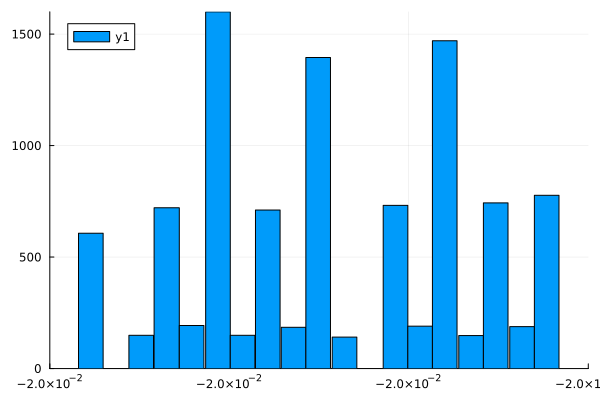

GKS: Possible loss of precision in routine SET_WINDOW


In [47]:
histogram(filter(x -> abs.(x) < 1.0, rep_err))

In [48]:
ang_err = sin.(pi .* rep_err);

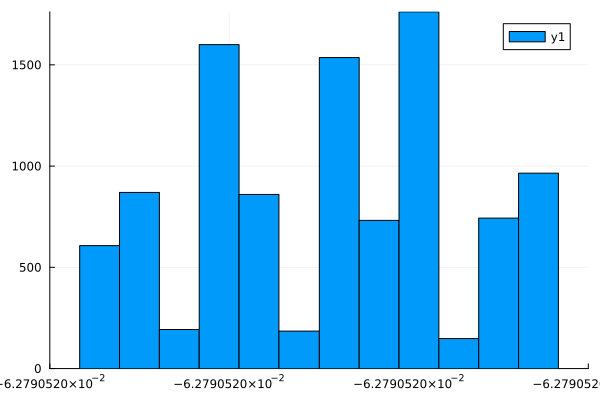

In [49]:
histogram(ang_err)